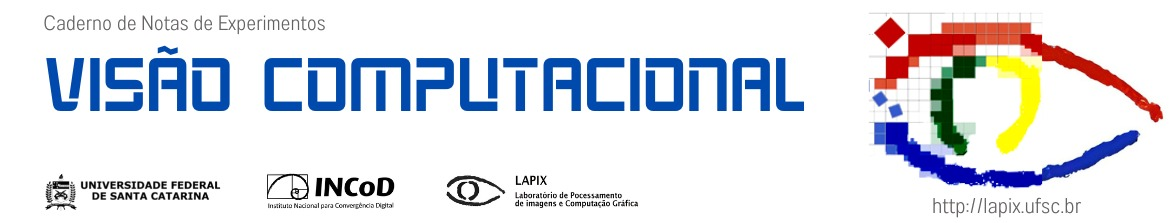






<a href="https://colab.research.google.com/github/awangenh/vision/blob/master/jupyter/06.3.Segmenta%C3%A7%C3%A3o%20por%20Crescimento%20de%20Regi%C3%B5es%20-%20Algoritmos%20Avan%C3%A7ados.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="https://img.shields.io/badge/python-3.10-green" alt="Python Version" title="Python Version"></a>

# 06.2.Segmentação por Crescimento de Regiões - Algoritmos Avançados

A busca pelo sonho de consumo do algoritmo genérico para dividir uma imagem nos objetos ali representados levou ao desenvolvimento de algoritmos de segmentação bastante elaborados, que tentavam unir várias técnicas diferentes e várias representações diferentes do conteúdo de uma imagem: grafos dos objetos na imagem, representação de longos gradientes suaves por grandes regiões da imagem representando o mesmo objeto que variava de luminosidade, similaridade de pixel baseada em características específicas de imagens de satélite ou outras e por aí vai. Alguns players de peso como a NASA tentaram a sua sorte neste tipo de algoritmo.

A maioria desses algoritmos foram implementados em linguagens de programação compiladas e existiram apenas na forma de executáveis que podiam ser baixados ou de código fonte em linguagem C ou C++. Como a pesquisa nesses algoritmos é anterior ao grande sucesso da linguagem Python, que estamos vendo agora, e as pesquisas agora estão voltadas para o desenvolvimento de algoritmos baseados em aprendizado profundo, muito poucos dos algoritmos que discutimos na nossa aula de segmentação avançada acabaram recebendo uma implementação em Python. O algoritmo de segmentação baseado em gráficos de Felzenszwalb & Huttenlocher, que possui um nome tão prosaico que ele só é citado pelas suas iniciais FH, é um dos poucos exemplos que nós podemos executar em Python. Abaixo vão alguns exemplos de sua execução.



### Configurações GPU e PATH

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import os
import torch
from IPython import get_ipython
import os
# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    ![ -d vision ] || git clone https://github.com/awangenh/vision
else:
    BASE_PATH = "/lapix" # trocar para o base path do seu computador se estiver rodando localmente, deixar /lapix se estiver rodando nos conteiners lapix
    VISIBLE_GPUS = [7] # Selecionar a GPU PARA RODAR! VER QUAL ESTA LIVRE

    if torch.cuda.device_count() != 8:
        print("GPU SETADA - PULANDO ETAPA")
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        print("CUDA GPUS NUMBER: ", torch.cuda.device_count())
    
os.chdir(BASE_PATH) # garantir que está executando no caminho base definido

/home/awangenh/Documents/Aulas/VC/vision/jupyter
Linux note 6.2.0-36-generic #37~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Oct  9 15:34:04 UTC 2 x86_64 x86_64 x86_64 GNU/Linux
DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=22.04
DISTRIB_CODENAME=jammy
DISTRIB_DESCRIPTION="Ubuntu 22.04.3 LTS"
Running on Google Colab =  False


In [ ]:
if  _ON_COLAB:
    # If you are Running on Google Colab,
    # Move vision/data one level up, into the root folder
    !mv vision/data ..
!ls -al ..

total 20
drwxr-xr-x 1 root root 4096 Nov  3 18:20 .
drwxr-xr-x 1 root root 4096 Nov  3 18:21 ..
drwxr-xr-x 4 root root 4096 Nov  2 13:23 .config
drwxr-xr-x 1 root root 4096 Nov  2 13:24 sample_data
drwxr-xr-x 7 root root 4096 Nov  3 18:21 vision
mv: cannot stat 'vision/data': No such file or directory
total 116
drwxr-xr-x   1 root root  4096 Nov  3 18:21 .
drwxr-xr-x   1 root root  4096 Nov  3 18:21 ..
lrwxrwxrwx   1 root root     7 Jun  5 14:02 bin -> usr/bin
drwxr-xr-x   2 root root  4096 Apr 18  2022 boot
drwxr-xr-x   1 root root  4096 Nov  3 18:20 content
-rw-r--r--   1 root root  4332 Jun 21 00:40 cuda-keyring_1.0-1_all.deb
drwxr-xr-x   8 root root  4096 Nov  3 18:20 data
drwxr-xr-x   1 root root  4096 Nov  2 13:40 datalab
drwxr-xr-x   5 root root   360 Nov  3 18:19 dev
-rwxr-xr-x   1 root root     0 Nov  3 18:19 .dockerenv
drwxr-xr-x   1 root root  4096 Nov  3 18:19 etc
drwxr-xr-x   2 root root  4096 Apr 18  2022 home
lrwxrwxrwx   1 root root     7 Jun  5 14:02 lib -> usr/lib
lrw

#### Mount your Google Drive as a Folder

If you're using Google Colab together with your Google Drive, adapt this code below to point to the place where you've copied our Git in your Google Drive:

In [ ]:
# Code to mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Look at the contents of your Drive:

In [ ]:
!ln -s "/content/drive/My Drive"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from ipywidgets import interact, interactive, interact_manual
from skimage.data import astronaut
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

image = cv2.imread("../data/ct-02.jpg", cv2.IMREAD_GRAYSCALE)
#image = img_as_float(img[::2, ::2])


def my_fh(scale=100, sigma=0.5, min_size=50, colormap='magma'):
    global image
    colormap = eval('plt.cm.' + colormap)
    segments_fh = felzenszwalb(image, scale=scale, sigma=sigma, min_size=min_size)

    fig, ax = plt.subplots(ncols=2, figsize=(15, 7), sharex=True, sharey=True)

    ax[0].imshow(mark_boundaries(image, segments_fh))
    ax[0].set_title('Original with Boundaries: F&H')

    ax[1].imshow(segments_fh, cmap=colormap, interpolation='nearest')
    ax[1].set_title('Segments: Felzenszwalb & Huttenlocher')

    for a in ax:
        a.set_axis_off()


    plt.tight_layout()
    plt.show()

interactive(my_fh, scale=100, sigma=0.5, min_size=50, colormap = ['nipy_spectral', 'hot', 'magma', 'seismic'])

interactive(children=(IntSlider(value=100, description='scale', max=300, min=-100), FloatSlider(value=0.5, des…

### SciKit F&H with Color Images

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from ipywidgets import interact, interactive, interact_manual
from skimage.data import astronaut
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = cv2.imread("../data/car-01.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image = img_as_float(img[::2, ::2])


def my_fh(scale=100, sigma=0.5, min_size=50):
    global image
    segments_fh = felzenszwalb(image, scale=scale, sigma=sigma, min_size=min_size)

    fig, ax = plt.subplots(ncols=2, figsize=(19, 7), sharex=True, sharey=True)

    ax[0].imshow(mark_boundaries(image, segments_fh))
    ax[0].set_title('Original with Boundaries: F&H')

    ax[1].imshow(segments_fh, cmap=plt.cm.nipy_spectral, interpolation='nearest')
    ax[1].set_title('Segments: Felzenszwalb & Huttenlocher')

    for a in ax:
        a.set_axis_off()


    plt.tight_layout()
    plt.show()

interactive(my_fh, scale=100, sigma=0.5, min_size=50)

interactive(children=(IntSlider(value=100, description='scale', max=300, min=-100), FloatSlider(value=0.5, des…

### PEGBIS F&H Implementation

Here we will use the **PEGBIS** *(Python Efficient Graph-Based Image Segmentation)*, a Python implementation by Ghassem Alaee of the "Efficient Graph-Based Image Segmentation" paper written by P. Felzenszwalb, D. Huttenlocher. The paper is available: http://cs.brown.edu/~pff/papers/seg-ijcv.pdf. The C++ implementation is written by the author and is available on: http://cs.brown.edu/~pff/segment/.  You'll find the original author's implementation in https://github.com/salaee/pegbis. The version we are using here had a few adaptations and Python-updates by me. 

In [ ]:
# Do this once (or each time you restart the kernel if you're using Colab)
# Code below downloads the version stored in my mirror
# wget parameters: 
# --backups=1 : renames original file with .1 suffix and writes new file to the intended filename
# -q : run quiet unless there's an error
!wget --backups=1 -q https://raw.githubusercontent.com/awangenh/pegbis/master/segment_graph.py
!wget --backups=1 -q https://raw.githubusercontent.com/awangenh/pegbis/master/filter.py
!wget --backups=1 -q https://raw.githubusercontent.com/awangenh/pegbis/master/fh_segment.py
!wget --backups=1 -q https://raw.githubusercontent.com/awangenh/pegbis/master/disjoint_set.py

In [22]:
# --------------------------------------------------------------------------------
# Segment an image:
# Returns a color image representing the segmentation.
#
# Inputs:
#           in_image: image to segment.
#           sigma: to smooth the image.
#           k: constant for threshold function.
#           min_size: minimum component size (enforced by post-processing stage).
#
# Returns:
#           num_ccs: number of connected components in the segmentation.
# --------------------------------------------------------------------------------
from scipy import ndimage
import matplotlib.pyplot as plt
from filter import *
from segment_graph import *
from fh_segment import *
import time
from ipywidgets import interact, interactive, interact_manual

sigma = 0.5
scale = 100
min_size = 50
input_path = "../data/car-01.jpg"

# Loading the image
#input_image = ndimage.imread(input_path, flatten=False, mode=None)
input_image = plt.imread(input_path)

def my_pegbis(scale=100, sigma=0.5, min_size=50):
    global input_image

    print("processing...")
    output_image, elapsed_time = fh_segment(input_image, sigma, scale, min_size)
    print("Execution time: " + str(int(elapsed_time / 60)) + " minute(s) and " + str(int(elapsed_time % 60)) + " seconds")
    # displaying the result
    fig, ax = plt.subplots(ncols=2, figsize=(14, 7), sharex=True, sharey=True)

    ax[0].imshow(input_image)
    ax[0].set_title('Original')

    ax[1].imshow(output_image)
    ax[1].set_title('Segments: Felzenszwalb & Huttenlocher')

    for a in ax:
        a.set_axis_off()


    plt.tight_layout()
    plt.show()

interact_manual(my_pegbis, scale=(1, 1000), sigma=(0.1, 3.0), min_size=(10, 1000))

interactive(children=(IntSlider(value=100, description='scale', max=1000, min=1), FloatSlider(value=0.5, descr…

<function __main__.my_pegbis(scale=100, sigma=0.5, min_size=50)>

# Credits

* General tricks for displaying images were from here: https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html
* We also used a few general tips from: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html#sphx-glr-auto-examples-segmentation-plot-segmentations-py

![rodape lapix ufsc](../rodape-CC.png)